## Import library

In [1]:
import datetime 
from datetime import timedelta 
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

from sklearn import svm

In [51]:
print(matplotlib.__version__)

AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

## Data load

In [2]:
# df_israel_covid 이스라엘 데이터셋
# corona_isolation_per_day_ver_0059 일일 코로나 격리자 수 
# time_series_covid19_confirmed_global 누적 확진자 수 

base_path = './opendataset'
df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_small.csv')
df_israel_isolation_per_day = pd.read_csv(f'{base_path}/corona_isolation_per_day_ver_0069.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

In [3]:
df_timeseries_confirm.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,152960,152960,153148,153220,153260,153306,153375,153375,153375,153534
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,144079,144847,145333,146387,147369,148222,149117,150101,150997,151499
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,194671,195162,195574,196080,196527,196915,197308,197659,198004,198313
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15025,15025,15032,15033,15046,15052,15055,15055,15055,15069
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,47079,47168,47331,47544,47781,48004,48261,48475,48656,48790


## preprocessing

In [4]:
# 누적 확진자수를 2021-08-17 와 같은 포멧으로 전처리해주는 과정

rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [5]:
# 누적 확진자를 통해 일일 확진자 구하기

df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [6]:
# 일일 확진자수가 음수인 경우 그 전날 확진자를 가져다 쓰는 과정

for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34



In [7]:
df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
589,2021-09-02,1096881,13900
590,2021-09-03,1104971,8090
591,2021-09-04,1112964,7993
592,2021-09-05,1117596,4632
593,2021-09-06,1117596,0


In [8]:
df_israel_covid = df_israel_covid[df_israel_covid['test_date'] < '2021-09-01']
df_israel_covid = df_israel_covid[df_israel_covid['test_date'] >= '2021-06-01']
df_israel_isolation_per_day = df_israel_isolation_per_day[df_israel_isolation_per_day['date'] < '2021-09-01']
df_israel_isolation_per_day = df_israel_isolation_per_day[df_israel_isolation_per_day['date'] >= '2021-06-01']
df_numsum_confirmed = df_numsum_confirmed[df_numsum_confirmed['confirmed_date'] < '2021-09-01']
df_numsum_confirmed = df_numsum_confirmed[df_numsum_confirmed['confirmed_date'] >= '2021-06-01']

In [9]:
df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
583,2021-08-27,1034623,6352
584,2021-08-28,1045800,11177
585,2021-08-29,1051609,5809
586,2021-08-30,1061488,9879
587,2021-08-31,1066352,4864


In [10]:
df_israel_isolation_per_day['join_date'] = (pd.to_datetime(df_israel_isolation_per_day['date']) + timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 요일을 숫자로 기록한 컬럼 하나 만듬
df_israel_covid['weekday'] = pd.to_datetime(df_israel_covid['test_date']).dt.dayofweek

In [11]:
df_israel_covid['test_date'].describe()

count          11602
unique            92
top       2021-08-23
freq             252
Name: test_date, dtype: object

In [12]:
df_israel_isolation_per_day['join_date'].describe()

count             92
unique            92
top       2021-06-05
freq               1
Name: join_date, dtype: object

In [13]:
df_numsum_confirmed.describe()

,confirmed_numsum,confirmed_num
count,9.200000e+01,92.000000
mean,8.838310e+05,2466.054348
std,6.347984e+04,3121.443944
min,8.395110e+05,0.000000
25%,8.403892e+05,140.250000
50%,8.505360e+05,908.000000
75%,9.019628e+05,4274.500000
max,1.066352e+06,12113.000000


In [14]:
# 기존 이스라엘 데이터에 격리자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_israel_isolation_per_day, how='left', left_on='test_date', right_on='join_date')
print("After merge:", df_israel_covid.shape)
df_israel_covid = df_israel_covid.sort_values('test_date')
df_israel_covid.head(5)

After merge: (11602, 18)


,Unnamed: 0,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,weekday,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date
0,1183158,2021-06-01,0,0,0,0,0,שלילי,NaN,NaN,Other,1,NaN,NaN,NaN,NaN,NaN,NaN
22,1182576,2021-06-01,0,0,0,0,0,אחר,NaN,NaN,Other,1,NaN,NaN,NaN,NaN,NaN,NaN
23,1180371,2021-06-01,0,0,0,0,0,שלילי,NaN,NaN,Other,1,NaN,NaN,NaN,NaN,NaN,NaN
24,1181561,2021-06-01,0,0,0,0,0,שלילי,NaN,NaN,Other,1,NaN,NaN,NaN,NaN,NaN,NaN
25,1179102,2021-06-01,0,0,0,0,0,שלילי,NaN,NaN,Other,1,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# 기존 이스라엘 데이터에 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')
print("After merge accumulated: ", df_israel_covid.shape[0])

After merge accumulated:  11602


In [16]:
head_ne = df_israel_covid[df_israel_covid['head_ache'] == 0]
head_po = df_israel_covid[df_israel_covid['head_ache'] == 1]
print(head_ne.shape[0]+head_po.shape[0])

11602


null 값이 있는지 확인

In [17]:
# 없어야함.
df_israel_covid[df_israel_covid['confirmed_num'].isnull()].shape

(0, 21)

## 번역하기

In [18]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [19]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [20]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [21]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [22]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

In [23]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)).astype(int)
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    print(len(data))
    print(test_indices.dtype)
    print(train_indices.dtype)
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
    test_data = data[test_indices]
    train_data = data[train_indices]
    
    return train_data, test_data

In [24]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

## model input preprocessing

In [25]:
# other 빼버림
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]

In [26]:
df_israel_covid_without_o.shape[0]

11083

In [27]:
# 성별 없는 사람들 빼버림
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]

In [28]:
df_israel_covid_without_o.shape[0]

8963

In [29]:
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [30]:
df_israel_covid_without_o['test_date'].min()

'2021-06-05'

In [31]:
# # week_num 이라는 칼럼을 새로 만들었다. 1년에 52주라 
# def date_to_weeknum_map(test_date):
#     week_num_st_idx = 52
#     year_last_num = int(test_date[2:4])
#     week_num = datetime.date(int(test_date[:4]), int(test_date[5:7]), int(test_date[8:])).isocalendar()[1]
#     return week_num_st_idx * year_last_num + week_num

In [32]:
# df_israel_covid_without_o['week_num'] = df_israel_covid_without_o['test_date'].apply(date_to_weeknum_map)

# Add 2nd degree data
추가 feature
- new_contact_with_confirmed
- positive_ratio
- weekday_ratio
- confirmed_ratio

In [33]:
df_israel_covid_without_o['new_contact_with_confirmed'] = df_israel_covid_without_o['new_contact_with_confirmed'].astype(int)

In [34]:
# 36903이 뭔지?
df_israel_covid_without_o['contact'] = df_israel_covid_without_o['new_contact_with_confirmed'] / df_israel_covid_without_o['new_contact_with_confirmed'].max()

In [35]:
df_confirm_by_sampling = df_israel_covid_without_o[df_israel_covid_without_o['corona_result'] == 1].groupby('test_date').count().reset_index()[['test_date', 'date']]
df_confirm_by_sampling = df_confirm_by_sampling.rename(columns={'test_date': 'yesterday', 'date': 'positive_cnt'})

In [36]:
df_israel_covid_without_o = pd.merge(df_israel_covid_without_o, df_confirm_by_sampling, how='left', left_on='date', right_on='yesterday')

In [37]:
df_israel_covid_without_o.shape[0]

8963

In [38]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['positive_cnt'].isnull()]

In [39]:
df_israel_covid_without_o['positive_cnt'] = df_israel_covid_without_o['positive_cnt'].astype(int)

In [40]:
df_israel_covid_without_o['positive_ratio'] = df_israel_covid_without_o['positive_cnt'] / df_israel_covid_without_o['positive_cnt'].max()

In [41]:
df_israel_covid_without_o['weekday_ratio'] = df_israel_covid_without_o['weekday'] / 6

In [42]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / df_israel_covid_without_o['confirmed_num'].max()

In [43]:
df_israel_covid_without_o.columns

Index(['Unnamed: 0', 'test_date', 'cough', 'fever', 'sore_throat',
       'shortness_of_breath', 'head_ache', 'corona_result', 'age_60_and_above',
       'gender', 'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num', 'contact',
       'yesterday', 'positive_cnt', 'positive_ratio', 'weekday_ratio',
       'confirmed_ratio'],
      dtype='object')

In [44]:
# 여기서 내가 사용할 feature 고르기
# df_input = = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']]
df_input = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'confirmed_ratio', 'weekday_ratio', 'corona_result']]
raw_datas = df_input.values

In [45]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,confirmed_ratio,weekday_ratio,corona_result
count,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000
mean,0.017704,0.017566,0.007884,0.001521,0.012310,0.062102,0.539004,0.400977,0.433679,0.072337
std,0.131882,0.131376,0.088446,0.038979,0.110272,0.467378,0.498511,0.252509,0.338471,0.259064
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.040948,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181210,0.166667,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.368530,0.333333,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.600760,0.666667,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

7230
int64
int64
5784
int64
int64


In [47]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(4628, 9) (4628,) (1156, 9) (1156,) (1446, 9) (1446,)


In [48]:
print("# of train data positive: ", train_gt.sum())
print("# of train data negative: ", train_gt.shape[0] - train_gt.sum())
print("ratio of P/N: ", train_gt.sum()/(train_gt.shape[0] - train_gt.sum()))
print("")

print("# of valid data positive: ", valid_gt.sum())
print("# of valid data negative: ", valid_gt.shape[0] - valid_gt.sum())
print("ratio of P/N: ", valid_gt.sum()/(valid_gt.shape[0] - valid_gt.sum()))
print("")

print("# of test data positive: ", test_gt.sum())
print("# of test data negative: ", test_gt.shape[0] - test_gt.sum())
print("ratio of P/N: ", test_gt.sum()/(test_gt.shape[0] - test_gt.sum()))

# of train data positive:  318.0
# of train data negative:  4310.0
ratio of P/N:  0.07378190255220418

# of valid data positive:  86.0
# of valid data negative:  1070.0
ratio of P/N:  0.08037383177570094

# of test data positive:  119.0
# of test data negative:  1327.0
ratio of P/N:  0.08967596081386586


In [271]:
class IsraelDataset(Dataset):
    def __init__(self, input_data, gt, transform=None, target_transform=None):
        self.input_data = input_data
        self.gt = gt
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.gt[idx]

In [272]:
# def plot_roc_curve(fper, tper):
#     plt.plot(fper, tper, color='red', label='ROC')
#     plt.plot([0, 1], [0, 1], color='green', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic Curve')
#     plt.legend()
#     plt.show()

In [273]:
def display_performance(clf, pred, valid_input, valid_gt):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    plot_roc_curve(clf, valid_input, valid_gt)

In [274]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.fcs1 = nn.Sequential(
            nn.BatchNorm1d(9),
            nn.Linear(9, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs2 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs3 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs4 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs5 = nn.Sequential(
            nn.Linear(400, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.fcs1(x)
        x = x + self.fcs2(x)
        x = x + self.fcs3(x)
        x = x + self.fcs4(x)
        pred = self.fcs5(x)
        return pred

In [275]:
training_data = IsraelDataset(torch.Tensor(train_input), torch.Tensor(train_gt.reshape(-1, 1)))
valid_data = IsraelDataset(torch.Tensor(valid_input), torch.Tensor(valid_gt.reshape(-1, 1)))

train_dataloader = DataLoader(training_data, batch_size = 128, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

valid_input.shape

(1156, 9)

In [276]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [277]:
model = BaselineModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr 크기좀 늘려보기

In [278]:
def show_progress(train_history, val_history):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.legend()
    plt.show()


Done. Train loss:0.37044215202331543, Vlidation loss: 0.2569316327571869


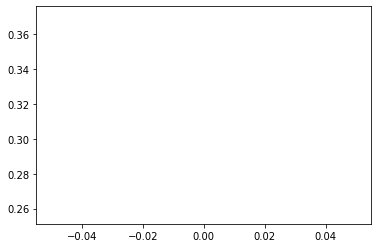


Done. Train loss:0.2166023552417755, Vlidation loss: 0.2712671756744385


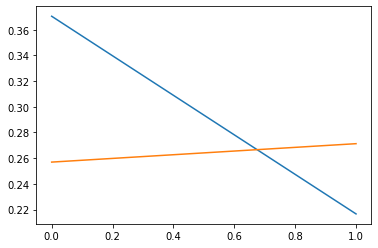


Done. Train loss:0.211492657661438, Vlidation loss: 0.2752034664154053


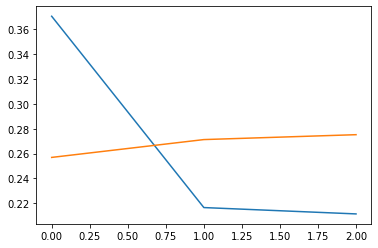


Done. Train loss:0.20711855590343475, Vlidation loss: 0.2790749669075012


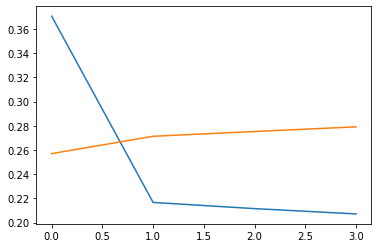


Done. Train loss:0.20491038262844086, Vlidation loss: 0.27552711963653564


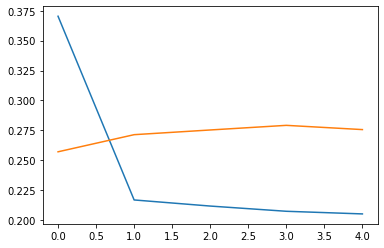


Done. Train loss:0.1999201774597168, Vlidation loss: 0.26774266362190247


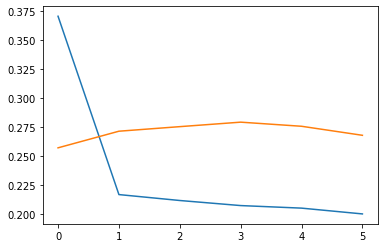


Done. Train loss:0.1956268846988678, Vlidation loss: 0.2667495608329773


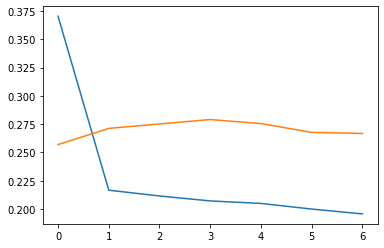


Done. Train loss:0.1929742991924286, Vlidation loss: 0.2705572843551636


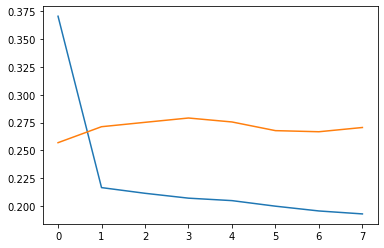


Done. Train loss:0.1903105229139328, Vlidation loss: 0.2697572410106659


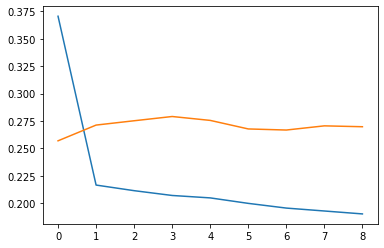


Done. Train loss:0.18742814660072327, Vlidation loss: 0.2720280885696411


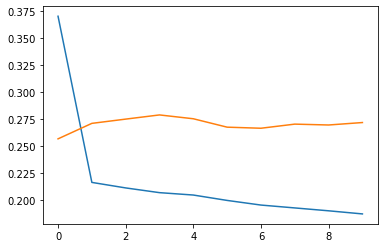


Done. Train loss:0.1858753263950348, Vlidation loss: 0.2726910710334778


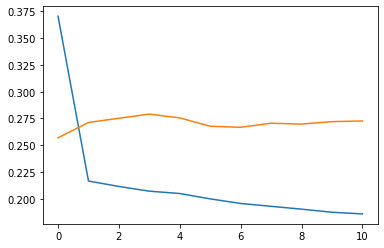


Done. Train loss:0.18468531966209412, Vlidation loss: 0.27255579829216003


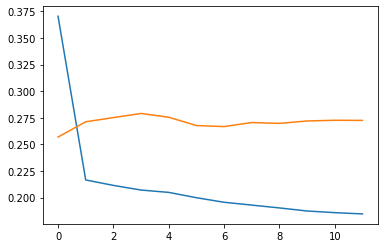


Done. Train loss:0.18279647827148438, Vlidation loss: 0.27346694469451904


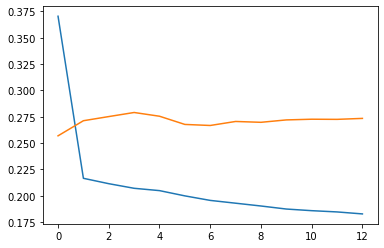


Done. Train loss:0.18095262348651886, Vlidation loss: 0.2742830812931061


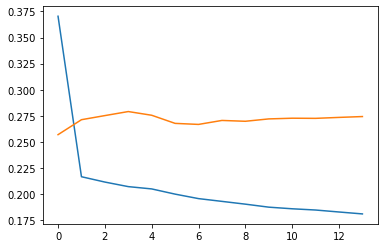


Done. Train loss:0.17844587564468384, Vlidation loss: 0.27159103751182556


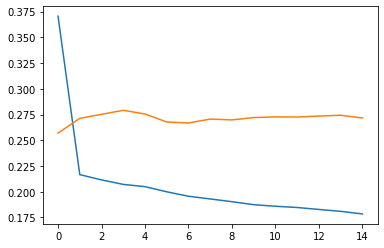


Done. Train loss:0.17576804757118225, Vlidation loss: 0.2776314914226532


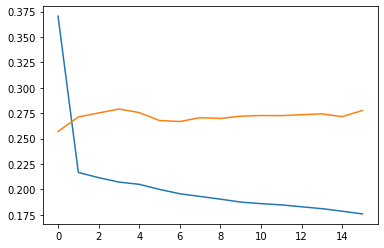


Done. Train loss:0.17424581944942474, Vlidation loss: 0.27689868211746216


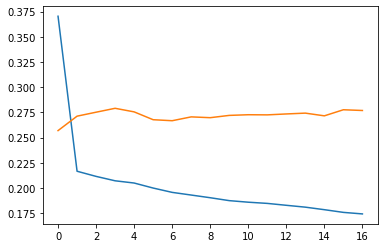


Done. Train loss:0.17174668610095978, Vlidation loss: 0.27777785062789917


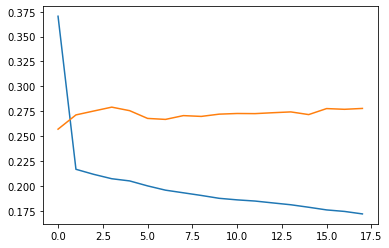


Done. Train loss:0.1695677936077118, Vlidation loss: 0.28738877177238464


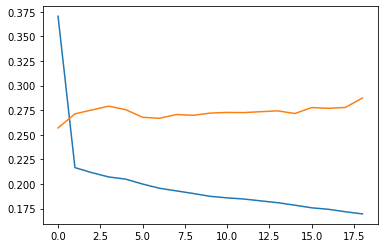


Done. Train loss:0.1690891832113266, Vlidation loss: 0.2850084900856018


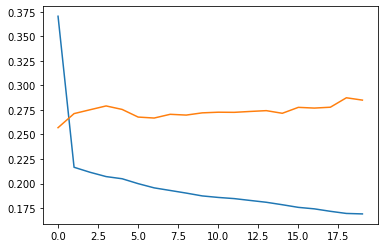

In [279]:
train_running_loss = 0.0
num_epochs = 20

train_history = []
val_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    for train_data in tqdm(train_dataloader):
        train_inputs, train_labels = train_data
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss)
    
    model.eval()
    
    val_losses = []
    for valid_data in valid_dataloader:
        val_inputs, val_labels = valid_data
        val_outputs = model(torch.Tensor(val_inputs).to(device))
        
        val_loss_on_batch = criterion(val_outputs, val_labels)
        val_losses.append(val_loss_on_batch)
    
    total_val_loss = sum(val_losses) / len(valid_dataloader)
    total_train_loss = sum(train_losses) / len(train_dataloader)
    print('Done. Train loss:{}, Vlidation loss: {}'.format(total_train_loss, total_val_loss))
    
    train_history.append(total_train_loss)
    val_history.append(total_val_loss)
    
    show_progress(train_history, val_history)
    
    

### 8-feature - epoch 1
- accuracy 0.8779
- precision 0.2652
- recall 0.4887
- f1-score 0.3438

### 8-feature - epoch 10
- accuracy 0.1348
- precision 0.9928
- recall 0.1217
- f1-score 0.2169

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed)
- accuracy 0.8793
- precision 0.0000
- 모두 음성으로 판단하는 대참사

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed) - epoch 5
- accuracy 0.8699
- precision 0.5792
- recall 0.4685
- f1-score 0.5180

### 9-feature(contact) - epoch 20
- accuracy 0.8702
- precision 0.2208
- recall 0.4144
- f1-score 0.2881

### 9-feature(positive ratio) - epoch 20
- accuracy 0.7904
- precision 0.5766
- recall 0.3010
- f1-score 0.3956

### 10-feature( 'positive_ratio', 'contact') - epoch 20
- accuracy 0.8713
- precision 0.5797
- recall 0.4671
- f1-score 0.5174

### 12-feature('contact', 'positive_ratio', 'weekday_ratio', 'confirmed_ratio') - epoch 20
- accuracy 0.8698
- precision 0.5809
- recall 0.4650
- f1-score 0.5166


accuracy 0.8793
precision 0.1684
recall 0.4877
f1-score 0.2503
[[740307  85788]
 [ 18244  17368]]

In [265]:
df_pos = pd.DataFrame(np.array(positive_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])
df_neg = pd.DataFrame(np.array(negative_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])

NameError: name 'positive_res_data' is not defined

In [ ]:
print(f"양성 갯수: {df_pos.shape[0]}, 음성 갯수: {df_neg.shape[0]}, 양성 / 음성 비율: {round(df_pos.shape[0] / df_neg.shape[0] * 100, 2)}%")

In [ ]:
df_pos_symptom_cnt = [0] * 6
df_neg_symptom_cnt = [0] * 6
pos_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)
neg_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)

for idx, row in tqdm(df_pos.iterrows()):
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    pos_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_pos_symptom_cnt[cnt_idx] += 1
    
for idx, row in tqdm(df_neg.iterrows()):
    #     if idx == df_pos.shape[0]: break
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    neg_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_neg_symptom_cnt[cnt_idx] += 1

In [ ]:
df_pos.shape[0], df_neg.shape[0]

In [ ]:
def positive_percent_of_ormore_number(number):
    neg_ormore_num = sum(df_neg_symptom_cnt[number:])
    pos_ormore_num = sum(df_pos_symptom_cnt[number:])
    total = neg_ormore_num + pos_ormore_num
    if total == 0: 'lower the number'
    return round((pos_ormore_num / total) * 100, 2)

In [ ]:
print(f"음성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_neg_symptom_cnt[:6]}")
print(f"양성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_pos_symptom_cnt[:6]}\n")

for number in range(6):
    print(f"{number}개 이상] {positive_percent_of_ormore_number(number)}% 양성")
    print(f"증상 {number}개] 음성/양성% : {round(df_neg_symptom_cnt[number] / df_pos_symptom_cnt[number]*100, 2)}%\n")

In [ ]:
pos_symptom_confusion_matrix

In [ ]:
def confusion_matrix_display(confusion_matrix):
    for i in range(32):
        idx = bin(i).replace("0b", "0" * (7-len(bin(i))))
        cnt = 0
        if idx[0] == '1': 
            print('[ cough',end = ' ')
            cnt += 1
        if idx[1] == '1': 
            print('fever',end = ' ')
            cnt += 1
        if idx[2] == '1': 
            print('sore_throat',end = ' ')
            cnt += 1
        if idx[3] == '1': 
            print('shortness_of_breath',end = ' ')
            cnt += 1
        if idx[4] == '1': 
            print('head_ache',end = ' ')
            cnt += 1
        print(f'{cnt}개 증상 ]')
            
        print(confusion_matrix[int(idx[0]),int(idx[1]),int(idx[2]),int(idx[3]),int(idx[4])])

In [ ]:
confusion_matrix_display(neg_symptom_confusion_matrix)

In [ ]:
confusion_matrix_display(pos_symptom_confusion_matrix)

In [ ]:
pred = np.array(pred)

print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
print('precision %.4f' % (precision_score(pred, valid_gt)))
print('recall %.4f' % (recall_score(pred, valid_gt)))
print('f1-score %.4f' % (f1_score(pred, valid_gt)))
print(confusion_matrix(pred, valid_gt))

In [ ]:
pred
# pred_chk

### random forest result
- accuracy 0.9257
- precision 0.2314
- recall 0.5553
- f1-score 0.3267
- [[791936  52206]
- [ 12591  15720]]

### 1-layer sigmoid epoch3 result
- accuracy 0.9222
- precision 0.1958
- recall 0.5013
- f1-score 0.2816
- [[791299  54627]
- [ 13228  13299]]

### compare with logistic regression
- accuracy 0.9224
- precision 0.1953
- recall 0.5049
- f1-score 0.2816
- [[791517  54661]
- [ 13010  13265]]

### 2-layer epoch3 result
- 8-4-1(sig-sig)
- accuracy 0.9248
- precision 0.2626
- recall 0.5342
- f1-score 0.3521
- [[788976  50090]
-  [ 15551  17836]]

### 2-layer epoch3 result
- 8-4-1(relu-sig)
- accuracy 0.9256 
- precision 0.1999
- recall 0.5635
- f1-score 0.2951
- [[794008  54349]
- [ 10519  13577]]

### 2-layer epoch3 result
- 8-20-1(relu-sig)
- accuracy 0.9255
- precision 0.2392
- recall 0.5498
- f1-score 0.3333
- [[791226  51680]
-  [ 13301  16246]]

### 2-layer epcoh3 result 
- 8-400-1(relu-sig)
- accuracy 0.9256
- precision 0.2904
- recall 0.5415
- f1-score 0.3781
- [[787821  48197]
- [ 16706  19729]]

### 3-layer epoch3 result
- 8-4-2-1 (relu-relu-sigmoid) (sigmoid-sigmoid-sigmoid 동일한 결과)
- accuracy 0.9221
- precision 0.0000
- recall 0.0000
- f1-score 0.0000
- [[804527  67926]
-  [     0      0]]
- 확인 결과 모든 출력을 음성으로 출력함(1-layer가 오히려 낫네?)

## 시간 순서대로 train, valid, test 나눔

### Logistic Regression
- accuracy 0.8782
- precision 0.2240
- recall 0.4901
- f1-score 0.3075
- [[742649  81690]
  [ 24533  23581]]
  
### Random Forest
- accuracy 0.8761
- precision 0.4298
- recall 0.4848
- f1-score 0.4556
- [[719101  60026]
- [ 48081  45245]]

### Decision Tree
- accuracy 0.8761
- precision 0.4299
- recall 0.4848
- f1-score 0.4557
- [[719094  60017]
- [ 48088  45254]]

### Gradient Boosting 
- accuracy 0.8789
- precision 0.3059
- recall 0.4973
- f1-score 0.3788
- [[734633  73070]
- [ 32549  32201]]

### 3-layer NN 
- epochs = 10, batch_size = 128
- 8-1200-1
- accuracy 0.8699
- precision 0.5794
- recall 0.4683
- f1-score 0.5180
- [[697921  44274]
- [ 69261  60997]]